# Richter's Predictor: Modeling Earthquake Damage
_Hosted By DrivenData_

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by the Gorkha earthquake.

We're trying to predict the ordinal variable `damage_grade`, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

 1. represents low damage
 2. represents a medium amount of damage
 3. represents almost complete destruction

The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. 
 
To measure the performance of our algorithms, we'll use the _F1 score_ which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the _micro averaged F1 score_.
 
 - [Loading data](#Loading-data)
 - [Exploratory data analysis](#Exploratory-data-analysis)
 - [Correlation](#Correlation)
 - [Model training](#Model-training)
 - [Grid search with cross validation](#Grid-search-with-cross-validation)
    - [Random Forest Classifier](#Random-Forest-Classifier)
 - [Ensemble modeling](#Ensemble-modeling)
 - [Performance metric for DrivenData competition](#Performance-metric-for-DrivenData-competition)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path, PurePath
from time import time
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Loading data

In [3]:
project_root_dir = Path('/Users/angelo/Programming/data/modeling-earthquake-damage')
train_values_file = project_root_dir / 'train_values.csv'
train_labels_file = project_root_dir / 'train_labels.csv'
test_values_file = project_root_dir / 'test_values.csv'

In [4]:
train_values_df = pd.read_csv(train_values_file, index_col='building_id')
test_values_df = pd.read_csv(test_values_file, index_col='building_id')
train_labels_df = pd.read_csv(train_labels_file, index_col='building_id')

In [5]:
all_dataframes = [train_values_df, test_values_df]
all_regexes = ['has_', 'geo_level_']
for df in all_dataframes:
    for reg in all_regexes:
        filter_ = train_values_df.filter(regex=reg).columns
        df[filter_] = train_values_df[filter_].astype('object')

In [6]:
for df in all_dataframes:
    df.drop(['geo_level_2_id', 'geo_level_3_id'], axis='columns', inplace=True)

In [7]:
train_values_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 36 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  object
 1   count_floors_pre_eq                     260601 non-null  int64 
 2   age                                     260601 non-null  int64 
 3   area_percentage                         260601 non-null  int64 
 4   height_percentage                       260601 non-null  int64 
 5   land_surface_condition                  260601 non-null  object
 6   foundation_type                         260601 non-null  object
 7   roof_type                               260601 non-null  object
 8   ground_floor_type                       260601 non-null  object
 9   other_floor_type                        260601 non-null  object
 10  position                                260601 non-

In [8]:
num_attrib = train_values_df.select_dtypes('int64').columns
cat_attrib = train_values_df.select_dtypes('object').columns

In [9]:
train_values_df.head()

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
train_labels_df.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [11]:
train_values_df.nunique().sort_values(ascending=False)

area_percentage                           84
age                                       42
geo_level_1_id                            31
height_percentage                         27
count_families                            10
plan_configuration                        10
count_floors_pre_eq                        9
ground_floor_type                          5
foundation_type                            5
other_floor_type                           4
legal_ownership_status                     4
position                                   4
roof_type                                  3
land_surface_condition                     3
has_superstructure_mud_mortar_brick        2
has_superstructure_adobe_mud               2
has_superstructure_mud_mortar_stone        2
has_superstructure_stone_flag              2
has_superstructure_cement_mortar_stone     2
has_secondary_use_other                    2
has_secondary_use_use_police               2
has_superstructure_timber                  2
has_supers

In [12]:
train_values_df.isnull().sum()

geo_level_1_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engineered      0
has_superstructure_rc_engineered          0
has_superstructure_other        

In [13]:
train_values_df.describe().applymap('{:.2f}'.format)

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count,260601.00,260601.00,260601.00,260601.00,260601.00
mean,2.13,26.54,8.02,5.43,0.98
std,0.73,73.57,4.39,1.92,0.42
min,1.00,0.00,1.00,2.00,0.00
25%,2.00,10.00,5.00,4.00,1.00
50%,2.00,15.00,7.00,5.00,1.00
75%,2.00,30.00,9.00,6.00,1.00
max,9.00,995.00,100.00,32.00,9.00


In [14]:
test_values_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          0 non-null      object
 1   count_floors_pre_eq                     86868 non-null  int64 
 2   age                                     86868 non-null  int64 
 3   area_percentage                         86868 non-null  int64 
 4   height_percentage                       86868 non-null  int64 
 5   land_surface_condition                  86868 non-null  object
 6   foundation_type                         86868 non-null  object
 7   roof_type                               86868 non-null  object
 8   ground_floor_type                       86868 non-null  object
 9   other_floor_type                        86868 non-null  object
 10  position                                86868 non-null  object
 

In [15]:
test_values_df.head()

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,NaN,3,20,7,6,t,r,n,f,q,s,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99355,NaN,2,25,13,5,t,r,n,f,q,s,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890251,NaN,2,5,4,5,t,r,n,f,q,s,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745817,NaN,1,0,19,3,t,r,x,v,j,t,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421793,NaN,3,15,8,7,t,r,q,f,q,t,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
test_values_df.nunique().sort_values(ascending=False)

area_percentage                           73
age                                       36
height_percentage                         28
plan_configuration                        10
count_families                             9
count_floors_pre_eq                        8
ground_floor_type                          5
foundation_type                            5
other_floor_type                           4
legal_ownership_status                     4
position                                   4
land_surface_condition                     3
roof_type                                  3
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_secondary_use_other                    0
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_brick        0
has_superstructure_cement_mortar_stone     0
has_superstructure_cement_mortar_brick     0
has_secondary_use_use_police               0
has_superstructure_timber                  0
has_supers

## Exploratory data analysis

In [17]:
mod_num_attrib_list = list(num_attrib)
mod_num_attrib_list.append(train_values_df.join(train_labels_df).columns[-1])
mod_num_attrib_df = train_values_df.join(train_labels_df)[mod_num_attrib_list]

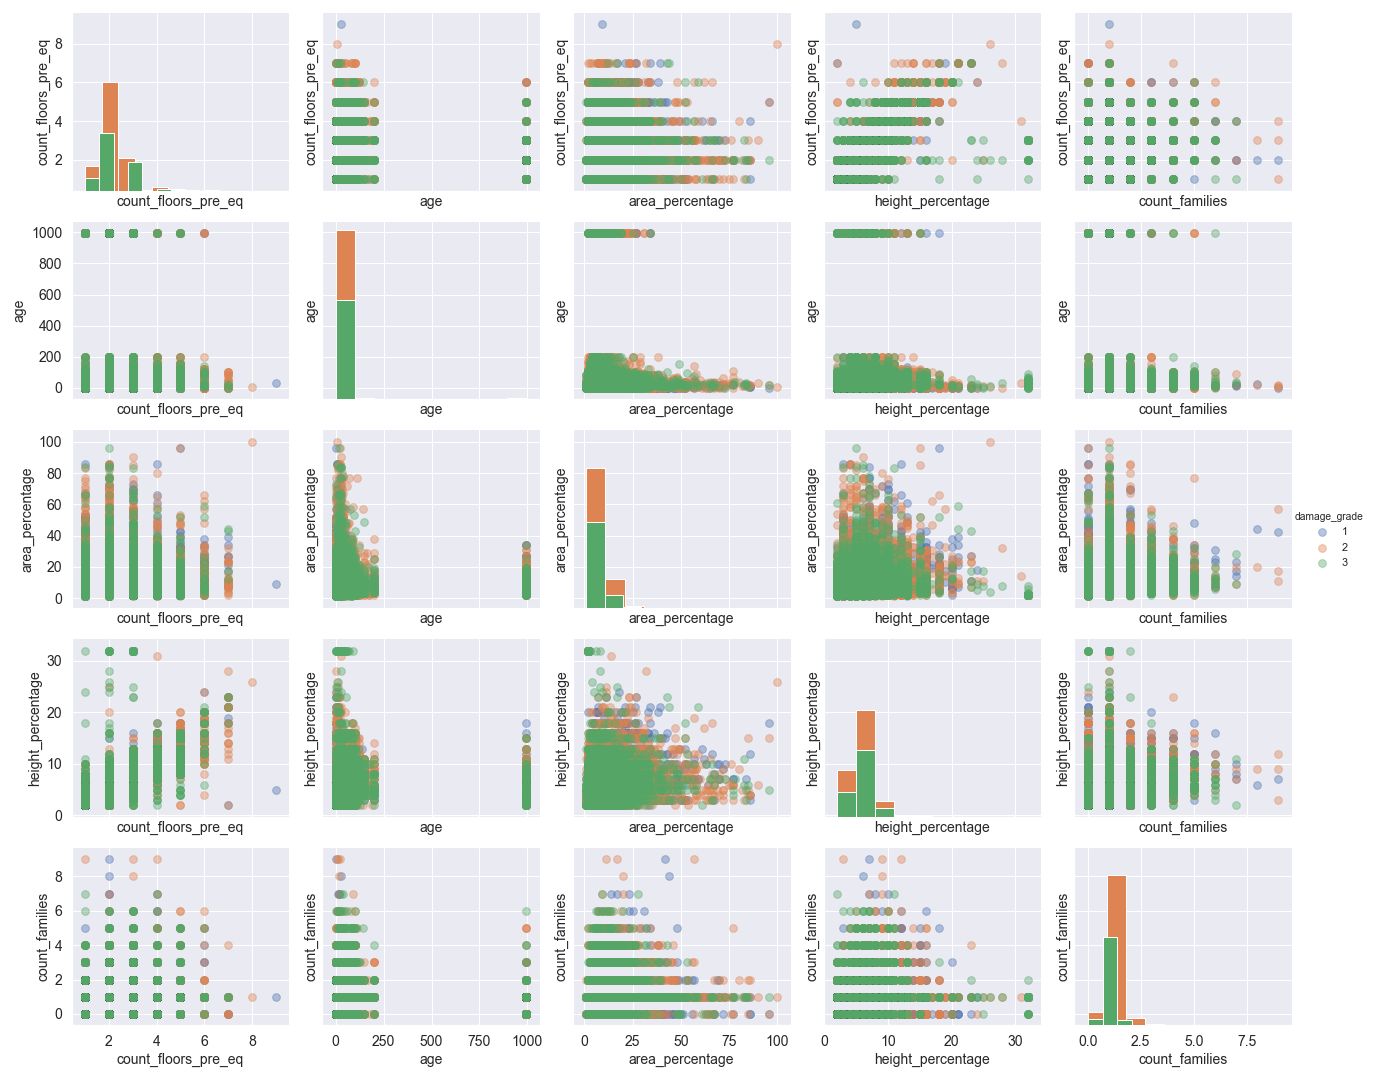

Time elasped: 0.0061 sec


In [18]:
t0 = time()
model_dir = Path('./earthquakes_models')
pairplot_file = PurePath.joinpath(model_dir, 'pairplot.png')
if pairplot_file.is_file():
    from IPython.display import Image
    display(Image(filename = pairplot_file))
else:
    sns.set(style='darkgrid', color_codes=True)
    g = sns.PairGrid(mod_num_attrib_df, hue='damage_grade', height=3.0, aspect=1.2)
    g = g.map_diag(plt.hist)
    g = g.map_offdiag(plt.scatter, s=60, alpha=0.4)
    g = g.add_legend()

    xlabels, ylabels = [], []
    label_font_size = 14

    for ax in g.axes[-1,:]:
        xlabel = ax.xaxis.get_label_text()
        xlabels.append(xlabel)
    for ax in g.axes[:,0]:
        ylabel = ax.yaxis.get_label_text()
        ylabels.append(ylabel)
        
    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            g.axes[j, i].xaxis.set_label_text(xlabels[i])
            g.axes[j, i].xaxis.label.set_size(label_font_size)
            g.axes[j, i].tick_params(axis='x', which='major', labelsize=label_font_size)
            g.axes[j, i].yaxis.set_label_text(ylabels[j])
            g.axes[j, i].yaxis.label.set_size(label_font_size)
            g.axes[j, i].tick_params(axis='y', which='major', labelsize=label_font_size)

    plt.tight_layout(rect=(0, 0, 0.95, 1))
    plt.savefig(pairplot_file)
print(f'Time elasped: {time() - t0:.4f} sec');

In [19]:
print(f'Categorical columns: {list(cat_attrib)}\n')
print(f'Number of categorical columns: {len(cat_attrib)}\n')

binary_cat_attrib = list(train_values_df.filter(regex='has_').columns)
geo_id_cat_attrib = list(train_values_df.filter(regex='geo_level_').columns)
print(f'Number of binary categorical columns: {len(binary_cat_attrib)}\n')

list_tuple_binary_cat_attrib = [(binary_cat_attrib[i], binary_cat_attrib[j]) for i, j in \
                                zip(range(0, len(binary_cat_attrib)-1, 2), range(1, len(binary_cat_attrib), 2))]

print(f'List of tuples: {list_tuple_binary_cat_attrib}\n')
print(f'Number of tuples: {len(list_tuple_binary_cat_attrib)}\n')

list_remainders = list(set(cat_attrib) - set(binary_cat_attrib) - set(geo_id_cat_attrib))
print(f'Remainder columns: {list(list_remainders)}\n')
print(f'Number of reminder columns: {len(list_remainders)}\n')

list_tuple_remainders = [(list_remainders[i], list_remainders[j]) for i, j in \
                         zip(range(0, len(list_remainders)-1, 2), range(1, len(list_remainders), 2))]
print(f'List tuple remainders: {list_tuple_remainders}')

Categorical columns: ['geo_level_1_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']

Number of categorical columns: 31

Number of binary categorical columns: 22

List of tu

In [20]:
def bar_plot(ax, df, col):
    for i in range(0, 2):
        df_col = df[col[i]].value_counts(ascending=False)
        df_col = df_col/df_col.sum()*100
        df_col = df_col.reset_index().rename(columns={'index': 'features'})
        ax[i].bar(df_col['features'], df_col[col[i]], color=colors, edgecolor='k')        
        if all(isinstance(tick, np.float64) for tick in ax[i].get_xticks()):
            ax[i].set_xticks(range(0, 2))
            ax[i].set_xticklabels(['No', 'Yes'])
        plt.setp(ax[i].get_xticklabels(), ha="right", rotation_mode="anchor", rotation=0, fontsize=14)
        plt.setp(ax[i].get_yticklabels(), fontsize=14)
        ax[i].set_ylabel('Percent (%)', fontsize=14)
        ax[i].set_title(col[i], fontsize=16)
        ax[i].grid(True, linestyle=':');

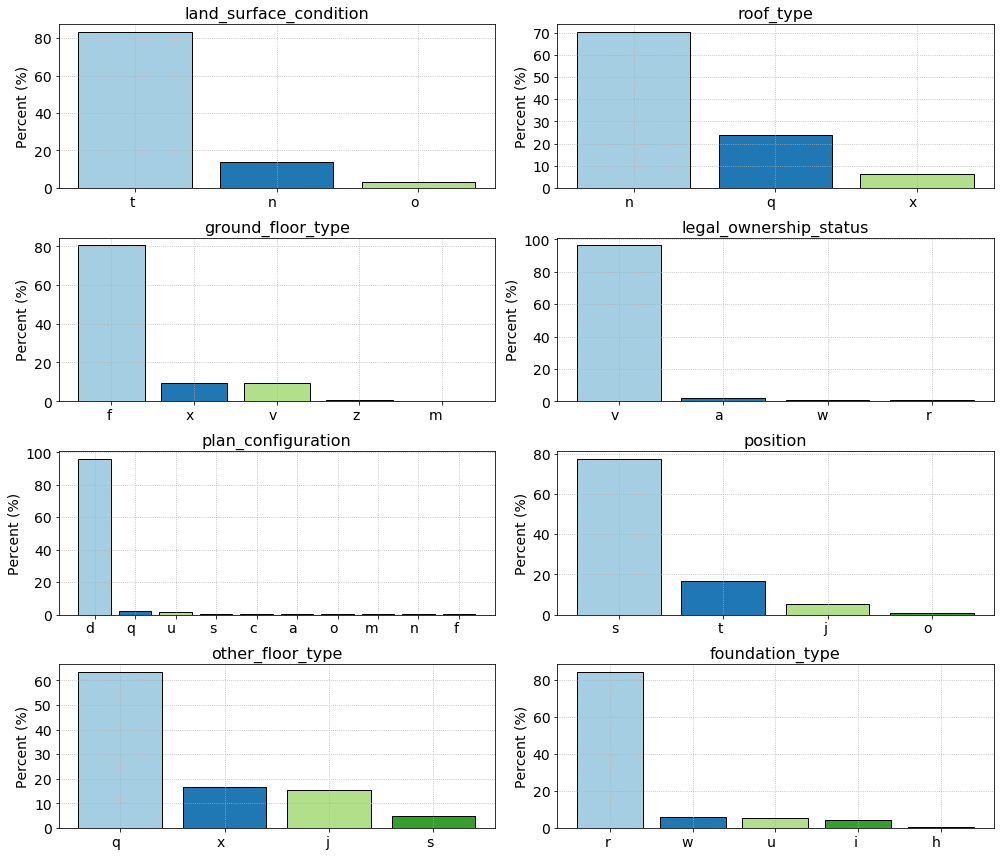

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
colors = plt.cm.Paired.colors
for ax, col in zip(axes, list_tuple_remainders):
    bar_plot(ax, train_values_df, col)
plt.tight_layout()

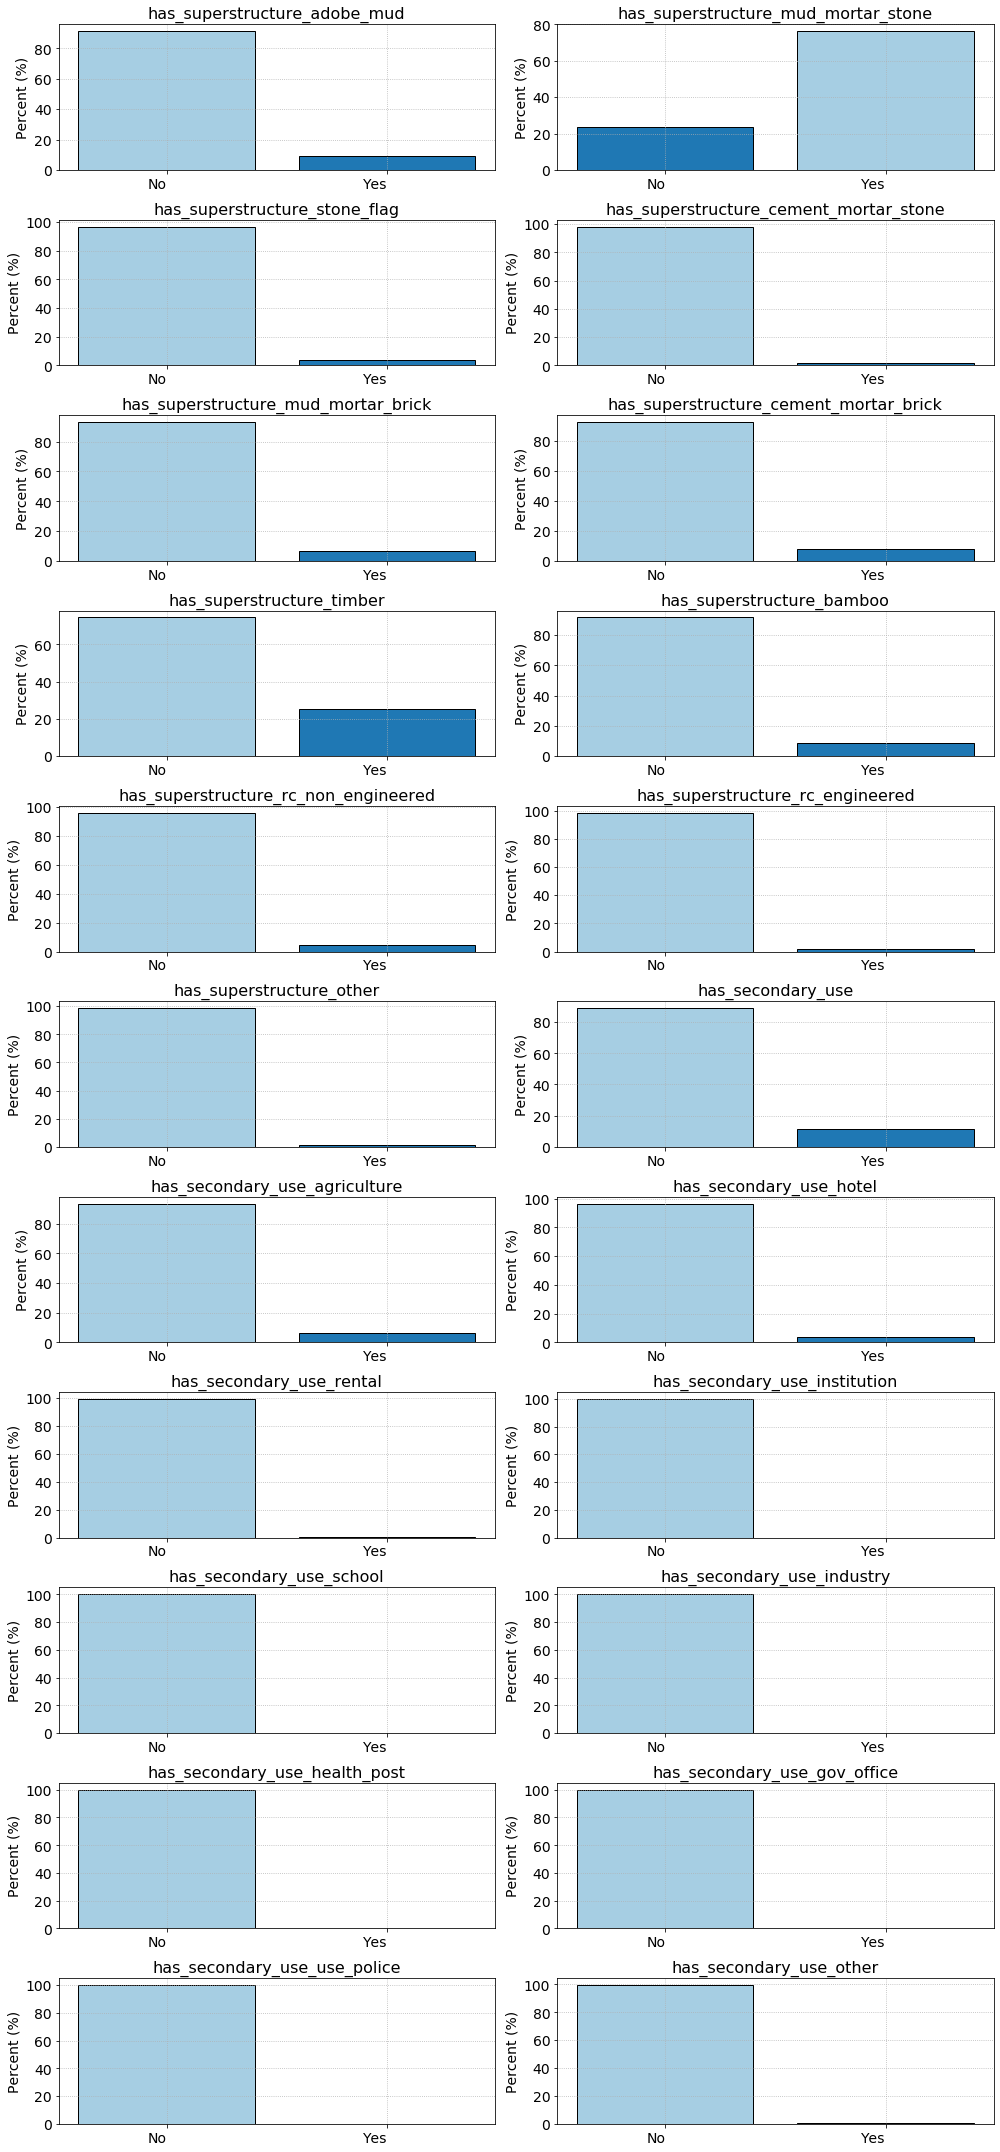

In [22]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(14, 30))
colors = plt.cm.Paired.colors
for ax, col in zip(axes, list_tuple_binary_cat_attrib):
    bar_plot(ax, train_values_df, col)
plt.tight_layout()

## Correlation

In [23]:
train_values_df[num_attrib].corr()

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count_floors_pre_eq,1.000000,0.086668,0.101071,0.772734,0.086586
age,0.086668,1.000000,-0.004323,0.061074,0.005309
area_percentage,0.101071,-0.004323,1.000000,0.196645,0.088630
height_percentage,0.772734,0.061074,0.196645,1.000000,0.064316
count_families,0.086586,0.005309,0.088630,0.064316,1.000000


## Model training

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from xgboost import XGBClassifier
from joblib import dump, load

In [25]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler())])
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attrib), ('cat', OneHotEncoder(), cat_attrib)])
train_values_prepared_df = full_pipeline.fit_transform(train_values_df)
X_train, X_test, y_train, y_test = train_test_split(train_values_prepared_df, train_labels_df, test_size = 0.3, random_state=42)
y_train, y_test = y_train.iloc[:,0], y_test.iloc[:,0]

In [26]:
print(f'X_train.shape: {X_train.shape:}\nX_test.shape: {X_test.shape}\n\
y_train.shape: {y_train.shape}\ny_test.shape: {y_test.shape}\n')

X_train.shape: (182420, 118)
X_test.shape: (78181, 118)
y_train.shape: (182420,)
y_test.shape: (78181,)



In [27]:
clf_dict = {'svc_clf': LinearSVC(C=1e3, dual=False, random_state=42), \
            'lr_clf': LogisticRegression(random_state=42, n_jobs=-1), \
            'dt_clf': DecisionTreeClassifier(random_state=42), \
            'extr_clf': ExtraTreesClassifier(random_state=42, n_jobs=-1), \
            'rf_clf': RandomForestClassifier(random_state=42, n_jobs=-1), \
            'xgb_clf': XGBClassifier(max_depth=200, n_estimators=100, n_jobs=-1)}

In [28]:
def print_accuracy(model_clf, t, X_test, y_test):
    y_pred = model_clf.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)
    print(f'Accuracy score for {model_clf.__class__.__name__}: {acc_score:.6f}', end=', ')
    print(f'time elapsed: {time() - t:.4f} sec')
    print(f'\nClassification report: {classification_report(y_pred, y_test)}')
    return acc_score

In [29]:
t0 = time()
list_files = [x for x in model_dir.iterdir() if x.is_file]
accuracy_score_dict = dict()
for key, clf in clf_dict.items():
    model_file = PurePath.joinpath(model_dir, key+'.sav')
    if model_file in list_files:
        t1 = time()
        model_clf = load(model_file)
        accuracy_score_dict[model_clf.__class__.__name__] = print_accuracy(model_clf, t1, X_test, y_test.values)
    else:
        t2 = time()
        clf.fit(X_train, y_train.values)
        dump(clf, model_file)
        accuracy_score_dict[clf.__class__.__name__] = print_accuracy(clf, t2, X_test, y_test.values)
print(f'\nTotal time elasped: {time() - t0:.4f} sec')

Accuracy score for LinearSVC: 0.665507, time elapsed: 0.0518 sec

Classification report:               precision    recall  f1-score   support

           1       0.26      0.62      0.36      3120
           2       0.83      0.67      0.74     55623
           3       0.50      0.67      0.57     19438

    accuracy                           0.67     78181
   macro avg       0.53      0.65      0.56     78181
weighted avg       0.73      0.67      0.68     78181

Accuracy score for LogisticRegression: 0.670035, time elapsed: 0.0400 sec

Classification report:               precision    recall  f1-score   support

           1       0.35      0.61      0.45      4360
           2       0.82      0.68      0.74     53639
           3       0.52      0.67      0.58     20182

    accuracy                           0.67     78181
   macro avg       0.56      0.65      0.59     78181
weighted avg       0.71      0.67      0.68     78181

Accuracy score for DecisionTreeClassifier: 0.611005

## Grid search with cross validation

### Random Forest Classifier

In [30]:
rf_clf = RandomForestClassifier()
params = {'max_depth': [50, 100, 200], 'min_samples_split': [5, 10, 20], 'min_samples_leaf': [1, 2, 5], 'random_state': [42], 'n_jobs': [-1]}
grid_search = GridSearchCV(rf_clf, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [31]:
t0 = time()
joblib_file = PurePath.joinpath(model_dir, 'grid_search.sav')
if joblib_file.is_file():
    grid_search = load(joblib_file)
else:
    grid_search.fit(X_train, y_train)
    dump(grid_search, PurePath.joinpath(model_dir, 'grid_search.sav'))
print(f'Time elapsed: {time() - t0:.4f} sec')

Time elapsed: 0.3963 sec


In [32]:
print(grid_search.best_params_)

{'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': -1, 'random_state': 42}


In [33]:
print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [34]:
print(grid_search.best_score_)

-0.3094233088477141


In [35]:
def grid_results(grid_search, num):
    cvres = grid_search.cv_results_
    best_fit_models = [(np.sqrt(-mean_score), params) for mean_score, params in zip(cvres['mean_test_score'], cvres['params'])]
    best_fit_models.sort(key=lambda x: x[0], reverse=False)
    print(f'List of best-fit models sorted by RMSE:')
    for rmse, params in best_fit_models[:num]:
        print(f'{rmse} {params}')

In [36]:
grid_results(grid_search, 8)

List of best-fit models sorted by RMSE:
0.5562583112616962 {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': -1, 'random_state': 42}
0.5562583112616962 {'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': -1, 'random_state': 42}
0.5563026564229689 {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': -1, 'random_state': 42}
0.5563519246788398 {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42}
0.5564947779544586 {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_jobs': -1, 'random_state': 42}
0.5564947779544586 {'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_jobs': -1, 'random_state': 42}
0.5567459137691354 {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42}
0.5567459137691354 {'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_jobs': -1, 'random_state': 42}


In [37]:
y_pred = grid_search.predict(X_test)
best_fit_acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy for the best-fit model: {best_fit_acc_score:.8f}')

Accuracy for the best-fit model: 0.70069454


In [38]:
print(f'''We have a {(100*(best_fit_acc_score-accuracy_score_dict['RandomForestClassifier'])/accuracy_score_dict['RandomForestClassifier']):.4f}% improvement.''')

We have a 4.7819% improvement.


## Ensemble modeling

In [39]:
voting_clf = VotingClassifier(estimators=list(clf_dict.items()), voting='hard', n_jobs=-1)

In [40]:
t0 = time()
joblib_file = PurePath.joinpath(model_dir, 'voting_clf.sav')
if joblib_file.is_file():
    voting_clf = load(joblib_file)
else:
    voting_clf.fit(X_train, y_train)
    dump(voting_clf, joblib_file)
print(f'Time elapsed: {time() - t0:.4f} sec')

Time elapsed: 15.0233 sec


In [41]:
t0 = time()
y_prediction_voting_clf = voting_clf.predict(X_test)
accuracy_score_voting_clf = accuracy_score(y_prediction_voting_clf, y_test)
print(f'Time elapsed: {time() - t0:.4f} sec')

Time elapsed: 7.8846 sec


In [42]:
accuracy_score_dict.update({'GridSearchCV': best_fit_acc_score, 'VotingClassifier': accuracy_score_voting_clf})
sorted_acc_score = [(val, key) for key, val in accuracy_score_dict.items()]

In [43]:
sorted_acc_score.sort(key=lambda val: val)

In [44]:
for score, name in sorted_acc_score:
    print(f'''Accuracy score for {name + ':':<25} {score:.6f}''')

Accuracy score for DecisionTreeClassifier:   0.611005
Accuracy score for ExtraTreesClassifier:     0.650810
Accuracy score for LinearSVC:                0.665507
Accuracy score for XGBClassifier:            0.667374
Accuracy score for RandomForestClassifier:   0.668717
Accuracy score for LogisticRegression:       0.670035
Accuracy score for VotingClassifier:         0.673783
Accuracy score for GridSearchCV:             0.700695


## Performance metric for DrivenData competition

In [45]:
print(f'''Micro-averaged F1 score for the GridSearchCV classifier: {f1_score(y_test, y_pred, average='micro'):.8f}''')

Micro-averaged F1 score for the GridSearchCV classifier: 0.70069454
